In [3]:
import numpy as np
import scipy.sparse
from scipy.sparse import diags, csr_matrix
from scipy.sparse.linalg import spsolve, gmres
import matplotlib.pyplot as plt
import time

考虑扩散方程：
$$

$$

一维扩散方程的显式格式：
$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\alpha \frac{u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}
$$
​
在Dirichlet边界条件下：
​
$$
\left[\begin{array}{c}
\mathrm{u}_{1}^{n+1} \\
\mathrm{u}_{2}^{n+1} \\
\vdots \\
\mathrm{u}_{\mathrm{J-1}}^{n+1} \\
\mathrm{u}_{\mathrm{J}}^{n+1}
\end{array}\right] = 
\left[\begin{array}{ccccccc}
 a_2 & a_3 & & &  \\
  a_1 & a_2 & a_3 & & \\
 & \ddots & \ddots & \ddots &  \\
 & & a_1 & a_2 & a_3 \\
 & & & a_1 & a_2  
\end{array}\right]
\left[\begin{array}{c}
\mathrm{u}_{1}^{n} \\
\mathrm{u}_{2}^{n} \\
\vdots \\
\mathrm{u}_{\mathrm{J-1}}^{n} \\
\mathrm{u}_{\mathrm{J}}^{n}
\end{array}\right]
$$
​
其中$a_2 = 1-\dfrac{2\alpha \Delta t}{\Delta x^2}, a_1 = a_3 = \dfrac{\alpha \Delta t}{\Delta x^2}$


一维扩散方程的隐式格式：
$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t}=\alpha \frac{u_{i+1}^{n+1}-2 u_{i}^{n+1}+u_{i-1}^{n+1}}{\Delta x^{2}}
$$

其中$a_2 = 1+\dfrac{2\alpha \Delta t}{\Delta x^2}, a_1 = a_3 = -\dfrac{\alpha \Delta t}{\Delta x^2}$

在Dirichlet边界条件下：

$$
\left[\begin{array}{ccccccc}
 a_2 & a_3 & & &  \\
  a_1 & a_2 & a_3 & & \\
 & \ddots & \ddots & \ddots &  \\
 & & a_1 & a_2 & a_3 \\
 & & & a_1 & a_2  
\end{array}\right]
\left[\begin{array}{c}
\mathrm{u}_{1}^{n+1} \\
\mathrm{u}_{2}^{n+1} \\
\vdots \\
\mathrm{u}_{\mathrm{J-1}}^{n+1} \\
\mathrm{u}_{\mathrm{J}}^{n+1}
\end{array}\right] = 
\left[\begin{array}{c}
\mathrm{u}_{1}^{n} \\
\mathrm{u}_{2}^{n} \\
\vdots \\
\mathrm{u}_{\mathrm{J-1}}^{n} \\
\mathrm{u}_{\mathrm{J}}^{n}
\end{array}\right]
$$

写成矩阵形式$Au^{n+1} = u^{n}$

则$u^{n+1} = A^{-1}u^{n}$

### 例子1 常系数
对于一般的对流扩散方程：
$$
u_t + \beta u_x = \alpha u_{xx}
$$

显式格式+迎风格式：
$$
\frac{u_{i}^{n+1}-u_{i}^{n}}{\Delta t} + \max\{\beta,0\} \frac{u_i^{n} - u_{i-1}^{n}}{\Delta x} + \min\{\beta,0\} \frac{u_{i+1}^{n} - u_{i}^{n}}{\Delta x}=\alpha \frac{u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}
$$

合并同类项：

$$
u_{i}^{n+1} = a_1 u_{i-1}^{n} + a_2 u_{i}^{n} + a_3 u_{i+1}^{n}
$$
$$
a_1 = \max\{\beta,0\}\frac{\Delta t}{\Delta x} + \alpha\frac{\Delta t}{\Delta x^2}
, \quad
a_2 = 1 - \max\{\beta,0\}\frac{\Delta t}{\Delta x} + \min\{\beta,0\}\frac{\Delta t}{\Delta x} - 2\alpha\frac{\Delta t}{\Delta x^2}
, \quad
a_3 = -\min\{\beta,0\}\frac{\Delta t}{\Delta x} + \alpha\frac{\Delta t}{\Delta x^2}
$$
于是，我们可以有
$$
u^{n+1} = Au^n
$$

隐式格式+迎风格式：
$$
\frac{u_{i}^{n}-u_{i}^{n-1}}{\Delta t} + \max\{\beta,0\} \frac{u_i^{n} - u_{i-1}^{n}}{\Delta x} + \min\{\beta,0\} \frac{u_{i+1}^{n} - u_{i}^{n}}{\Delta x}=\alpha \frac{u_{i+1}^{n}-2 u_{i}^{n}+u_{i-1}^{n}}{\Delta x^{2}}
$$
可以得到：
$$
u_i^{n-1}=(\frac{\Delta t\alpha}{\Delta x^{2}}-\frac{\Delta t}{\Delta x}\max\{\beta, 0\})u^n_{i-1}+(1+\frac{\Delta t}{\Delta x}\max\{\beta,0\}-\frac{\Delta t}{\Delta x}\min\{\beta,0\}-\frac{2\Delta t\alpha}{\Delta x^2})u_i^n+(\frac{\Delta t}{\Delta x}\min\{\beta,0\}+\frac{\Delta t\alpha}{\Delta x^2})u_{i+1}^n
$$

例子中，我们令$\alpha=1,\beta=0$。

alpha:0.100, beta:0.000, dx: 0.010, dt:0.010


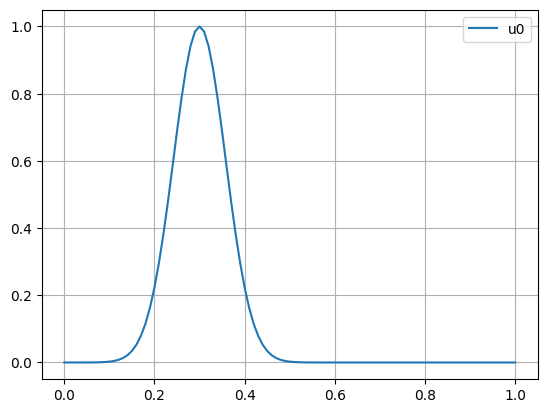

In [2]:
alpha = 0.1
beta = 0.0
x = np.linspace(0, 1,101)
u0 = np.exp(-150*(x-0.3)**2)
Nx = u0.shape[0]
dx = x[1] - x[0]
dt = 0.01
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.3f"%(alpha, beta, dx, dt))

plt.plot(x, u0, label="u0")
plt.legend()
plt.grid()

In [3]:
def RHSMatrix(alpha, beta, dx, dt, Nx, bc):
    # Nx: number of grid points in domain
    # bc: boundary condition
    a1 = max(beta,0)*dt/dx + alpha*dt/dx**2
    a2 = 1 - max(beta,0)*dt/dx + min(beta,0)*dt/dx - 2*alpha*dt/dx**2
    a3 = -min(beta,0)*dt/dx + alpha*dt/dx**2
    if bc == "Neumann":
        print("using Neumann boundary")
        A = csr_matrix(diags([a1, a2, a3],[-1,0,1], shape=(Nx,Nx)))
        A[0,1] += a1
        A[-1,-2] += a3
    elif bc == "Periodic":
        print("using Periodic boundary")
        A = csr_matrix(diags([a3, a1, a2, a3, a1],[1-Nx,-1,0,1,Nx-1], shape=(Nx,Nx)))
    else:
        print("using Dirichlet boundary")
        A = csr_matrix(diags([a1, a2, a3],[-1,0,1], shape=(Nx,Nx)))
    return A

In [4]:
def implict(alpha, beta, dx, dt, Nx, bc):
    a1 = -alpha*dt/dx**2 - max(beta,0)*dt/dx  
    a2 = 1 + max(beta,0)*dt/dx - min(beta,0)*dt/dx + 2*alpha*dt/dx**2
    a3 = min(beta,0)*dt/dx - alpha*dt/dx**2
    if bc == "Neumann":
        print("using Neumann boundary")
        A = csr_matrix(diags([a1, a2, a3],[-1,0,1], shape=(Nx,Nx)))
        A[0,1] += a1
        A[-1,-2] += a3
    elif bc == "Periodic":
        print("using Periodic boundary")
        A = csr_matrix(diags([a3, a1, a2, a3, a1],[1-Nx,-1,0,1,Nx-1], shape=(Nx,Nx)))
    else:
        print("using Dirichlet boundary")
        A = csr_matrix(diags([a1, a2, a3],[-1,0,1], shape=(Nx,Nx)))
    return A

CFL=0.5时候，我们这里使用显示格式：

alpha:0.100, beta:0.000, dx: 0.004, dt:0.0001
using Periodic boundary
耗时: 0.01596秒


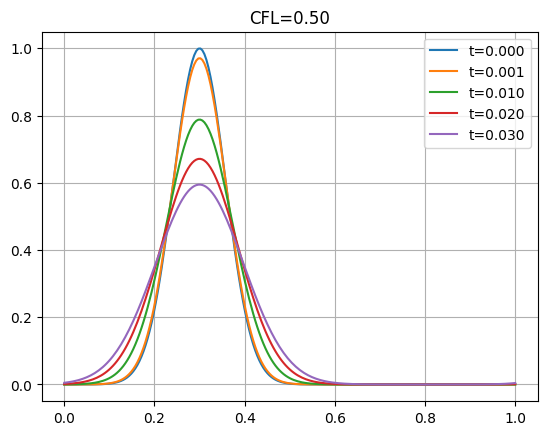

In [5]:
time_start = time.time()
CFL = 0.5
alpha = 0.1
beta = 0.0
dt = 0.0001
dx = np.sqrt(alpha*dt/CFL)
x0 = 0
xst = 1
Nx = int((xst - x0)/dx)
x = np.linspace(x0, xst, Nx)
u0 = np.exp(-150*(x-0.3)**2)
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.4f"%(alpha, beta, dx, dt))
A = RHSMatrix(alpha, beta, dx, dt, Nx, bc="Periodic")
Nt = 300
tst = Nt*dt

sol = np.zeros((Nt+1, Nx))
sol[0,:] = u0

for ti in range(Nt):
    sol[ti+1,:] = A @ sol[ti,:]

for ti in [0, 10, 100, 200, 300]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('CFL=%.2f'%(CFL))
plt.grid()
print("耗时: {:.5f}秒".format(time.time() - time_start))

Text(0.5, 0.5, 't')

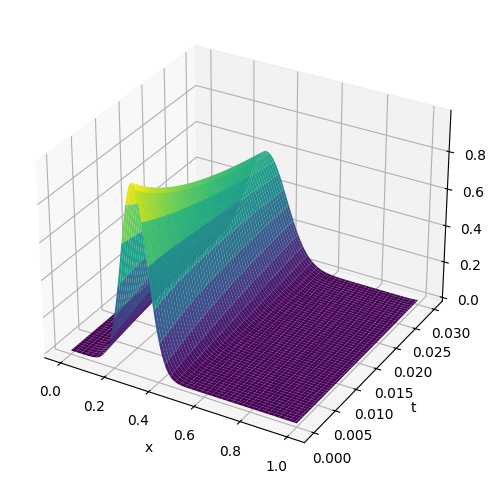

In [6]:
### plot 3D 
t = np.linspace(0, tst, Nt)
x = np.linspace(x0, xst, Nx)
fig1 = plt.figure(figsize=(8, 6), dpi=100)
ax = fig1.add_subplot(111, projection='3d')
X,T = np.meshgrid(x,t)
surface = ax.plot_surface(X, T, sol[1:], cmap='viridis', rstride=5, cstride=5, alpha=1, antialiased=True)
ax.set_xlabel('x')
ax.set_ylabel('t')

CFL=0.6 时候，我们发现显示格式不能使用

alpha:0.100, beta:0.000, dx: 0.004, dt:0.0001
using Periodic boundary


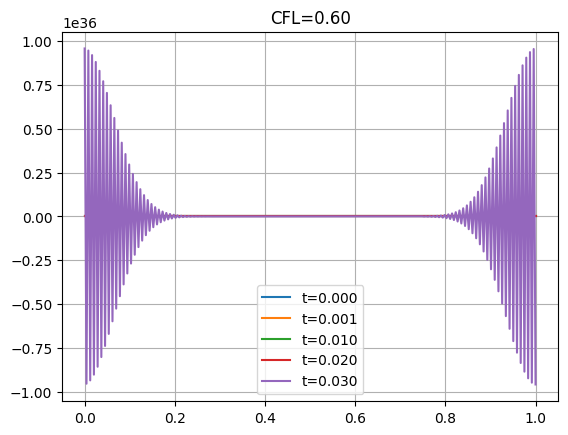

In [7]:
CFL = 0.6
alpha = 0.1
beta = 0.0
dt = 0.0001
dx = np.sqrt(alpha*dt/CFL)
x0 = 0
xst = 1
Nx = int((xst - x0)/dx)
x = np.linspace(x0, xst, Nx)
u0 = np.exp(-150*(x-0.3)**2)
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.4f"%(alpha, beta, dx, dt))
A = RHSMatrix(alpha, beta, dx, dt, Nx, bc="Periodic")
Nt = 300
T = Nt*dt

sol = np.zeros((Nt+1, Nx))
sol[0,:] = u0

for ti in range(Nt):
    sol[ti+1,:] = A @ sol[ti,:]

for ti in [0, 10, 100, 200, 300]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('CFL=%.2f'%(CFL))
plt.grid()

CFL=0.6 时，隐式格式依旧有效

alpha:0.100, beta:0.000, dx: 0.004, dt:0.0001
using Dirichlet boundary


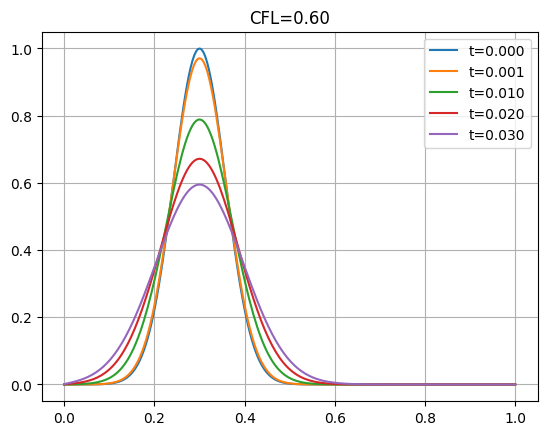

In [8]:
CFL = 0.6
alpha = 0.1
beta = 0.0
dt = 0.0001
dx = np.sqrt(alpha*dt/CFL)
x0 = 0
xst = 1
Nx = int((xst - x0)/dx)
x = np.linspace(x0, xst, Nx)
u0 = np.exp(-150*(x-0.3)**2)
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.4f"%(alpha, beta, dx, dt))
A = implict(alpha, beta, dx, dt, Nx, bc="dd").toarray()

A = np.linalg.inv(A)
Nt = 300
T = Nt*dt

sol = np.zeros((Nt+1, Nx))
sol[0,:] = u0

for ti in range(Nt):
    sol[ti+1,:] = A @ sol[ti,:]

for ti in [0, 10, 100, 200, 300]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('CFL=%.2f'%(CFL))
plt.grid()

### 使用循环的方法（不推荐）

alpha:0.100, beta:0.000, dx: 0.004, dt:0.0001
耗时: 0.06582秒


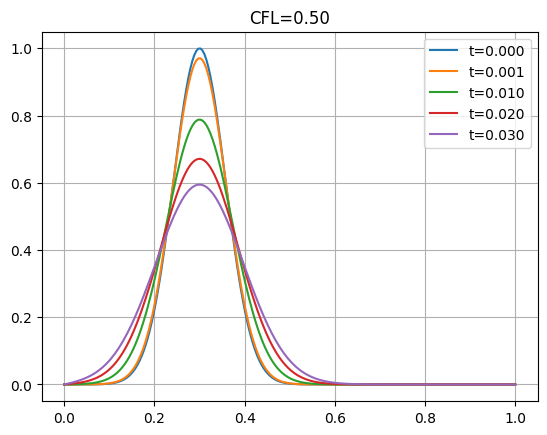

In [9]:
time_start = time.time()
CFL = 0.5
alpha = 0.1
beta = 0.0
dt = 0.0001
dx = np.sqrt(alpha*dt/CFL)
x0 = 0
xst = 1
Nx = int((xst - x0)/dx)
x = np.linspace(x0, xst, Nx)
u0 = np.exp(-150*(x-0.3)**2)
print("alpha:%.3f, beta:%.3f, dx: %.3f, dt:%.4f"%(alpha, beta, dx, dt))
Nt = 300
tst = Nt*dt

a1 = max(beta,0)*dt/dx + alpha*dt/dx**2
a2 = 1 - max(beta,0)*dt/dx + min(beta,0)*dt/dx - 2*alpha*dt/dx**2
a3 = -min(beta,0)*dt/dx + alpha*dt/dx**2
sol = np.zeros((Nt+1, Nx))
sol[0,:] = u0
for ti in range(Nt):
    for xi in range(1,Nx-1):
        sol[ti+1,xi] = a1*sol[ti,xi-1]+a2*sol[ti,xi]+a3*sol[ti,xi+1]
    sol[ti+1,0] = 0
    sol[ti+1,-1] = 0
for ti in [0, 10, 100, 200, 300]:
    plt.plot(x, sol[ti,:], label="t=%.3f"%(dt*ti))
plt.legend()
plt.title('CFL=%.2f'%(CFL))
plt.grid()
print("耗时: {:.5f}秒".format(time.time() - time_start))

使用这种循环的方法，耗时0.06984s;但是采用矩阵的方式，只需要0.01496秒

### 例子2 变系数

https://github.com/cantaro86/Financial-Models-Numerical-Methods/blob/master/2.1%20Black-Scholes%20PDE%20and%20sparse%20matrices.ipynb

考虑BS PDE
$$
\frac{\partial V(t,x)}{\partial t}+\left(r-\frac12\sigma^2\right)\frac{\partial V(t,x)}{\partial x}+\frac12\sigma^2\frac{\partial^2V(t,x)}{\partial x^2}-rV(t,x)=0.
$$
对于这种方程，我们一般知道它终止时刻的解，所以当构造如下格式的时候，我们是已知$V^{n+1}$计算$V^n$

执行价格：K, 终止时间：T

CALL：

终止时刻：
$$
V(T,x) = max(e^x-K,0)
$$

边界条件：
$$
\text{左边界:}\quad V(t,x)\operatorname*{=}_{x\to-\infty}0\quad \text{右边界:}\quad V(t,x)\operatorname*{\sim}_{x\to\infty}e^x-Ke^{-r(T-t)}
$$

离散格式：
$$
\frac{V_i^{n+1}-V_i^n}{\Delta t}+(r-\frac12\sigma^2)\frac{V_{i+1}^n-V_{i-1}^n}{2\Delta x}+\frac12\sigma^2\frac{V_{i+1}^n+V_{i-1}^n-2V_i^n}{\Delta x^2}-rV_i^n=0.
$$

这个是隐式格式，从$V^{n+1}$计算$V^n$

$$
\begin{aligned}
V_i^{n+1}& =V_i^n\left(1+r\Delta t+\sigma^2\frac{\Delta t}{\Delta x^2}\right)  \\
&+V_{i+1}^n\left(-(r-\frac12\sigma^2)\frac{\Delta t}{2\Delta x}-\frac12\sigma^2\frac{\Delta t}{\Delta x^2}\right) \\
&+V_{i-1}^n\bigg((r-\frac12\sigma^2)\frac{\Delta t}{2\Delta x}-\frac12\sigma^2\frac{\Delta t}{\Delta x^2}\bigg).
\end{aligned}
$$
可以改写成：
$$
V_i^{n+1}=aV_{i-1}^n+bV_i^n+cV_{i+1}^n,
$$
我们把它用矩阵的形式写出来：
$$
\begin{pmatrix}V_1^{n+1}\\V_2^{n+1}\\\vdots\\V_{M-2}^{n+1}\\V_{M-1}\end{pmatrix}=\underbrace{\begin{pmatrix}b&c&0&\cdots&0\\a&b&c&0&0\\0&\ddots&\ddots&\ddots&0\\\vdots&0&a&b&c\\0&0&0&a&b\end{pmatrix}}_{\mathcal{D}}\cdot\begin{pmatrix}V_1^n\\V_2^n\\\vdots\\V_{M-2}^n\\V_{M-1}^n\end{pmatrix}+\underbrace{\begin{pmatrix}aV_0^n\\0\\\vdots\\0\\cV_M^n\end{pmatrix}}_{\text{B (boundary terms)}}
$$

区间是：$[t_0, T]\times[A_1,A_2],\quad A_1 = log(K/3),\quad A_2=log(3K)$

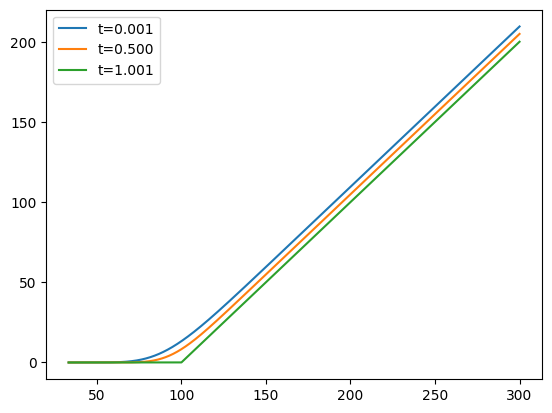

In [17]:
r = 0.1
sig = 0.2

K = 100
Texpir = 1
Nspace = 3000  # M space steps
Ntime = 2000  # N time steps

S_max = 3 * float(K)
S_min = float(K) / 3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1


x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

V = np.zeros((Nspace, Ntime))  # grid initialization
offset = np.zeros(Nspace - 2)  # vector to be used for the boundary terms

V[:, -1] = Payoff  # terminal conditions
V[-1, :] = np.exp(x_max) - K * np.exp(-r * T[::-1])  # boundary condition
V[0, :] = 0  # boundary condition

# construction of the tri-diagonal matrix D
sig2 = sig * sig
dxx = dx * dx

a = (dt / 2) * ((r - 0.5 * sig2) / dx - sig2 / dxx)
b = 1 + dt * (sig2 / dxx + r)
c = -(dt / 2) * ((r - 0.5 * sig2) / dx + sig2 / dxx)

D = scipy.sparse.diags([a, b, c], [-1, 0, 1], shape=(Nspace - 2, Nspace - 2)).tocsc()
# Backward iteration
for i in range(Ntime - 2, -1, -1):
    offset[0] = a * V[0, i]
    offset[-1] = c * V[-1, i]
    V[1:-1, i] = spsolve(D, (V[1:-1, i + 1] - offset))

CFL = sig*dt/dx**2
S = np.exp(x)

Text(0.5, 1.0, 'CFL=186.3894')

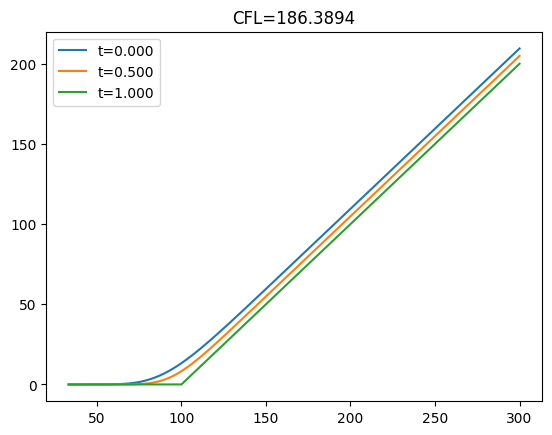

In [22]:
for ti in [1, 1000, 2000]:
    plt.plot(S, V[:,ti-1], label="t=%.3f"%(dt*(ti-1)))
plt.legend()
plt.title("CFL=%.4f"%CFL)

同样的，这里我们考虑一下显示格式：
$$
\frac{V_i^{n+1}-V_i^n}{\Delta t}+(r-\frac12\sigma^2)\frac{V_{i+1}^{n+1}-V_{i-1}^{n+1}}{2\Delta x}+\frac12\sigma^2\frac{V_{i+1}^{n+1}+V_{i-1}^{n+1}-2V_i^{n+1}}{\Delta x^2}-rV_i^{n+1}=0.
$$
于是有
$$
V_i^n = ((\frac{1}{2}\sigma^2-r)\frac{\Delta t}{2\Delta x}+\frac{\sigma^2\Delta t}{\Delta x^2})V_{i-1}^{n+1}+(1-\frac{\sigma^2\Delta t}{\Delta x^2}-r\Delta t)V_{i}^{n+1}+((r-\frac{1}{2}\sigma^2)\frac{\Delta t}{2\Delta x}+\frac{\sigma^2\Delta t}{\Delta x^2})V_{i+1}^{n+1}
$$

注意到边界条件，于是我们有：
$$

$$

In [ ]:
r = 0.1
sig = 0.2

K = 100
Texpir = 1
Nspace = 3000  # M space steps
Ntime = 2000  # N time steps

S_max = 3 * float(K)
S_min = float(K) / 3

x_max = np.log(S_max)  # A2
x_min = np.log(S_min)  # A1


x, dx = np.linspace(x_min, x_max, Nspace, retstep=True)  # space discretization
T, dt = np.linspace(0, Texpir, Ntime, retstep=True)  # time discretization
Payoff = np.maximum(np.exp(x) - K, 0)  # Call payoff

V = np.zeros((Nspace, Ntime))  # grid initialization

